# Split data

In [ ]:
import os

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

In [ ]:
df = pd.read_csv("./annotations/data.csv")
df

In [ ]:
# exists = np.isin(df["cluster"], os.listdir("./data"))
# df = df[exists]
# df = df.reset_index().rename(columns={"index": "label"})

In [ ]:
# Split data into train:valid:test = 80:10:10

np.random.seed(0)

n = len(df)
idx = np.random.permutation(n)
idx_train = idx[: int(0.8 * n)]
idx_valid = idx[int(0.8 * n) : int(0.9 * n)]
idx_test = idx[int(0.9 * n) :]

split = np.zeros(n, dtype=int)
split[idx_train] = 0
split[idx_valid] = 1
split[idx_test] = 2

df["split"] = split

df.to_csv("./annotations/data.csv", index=False)
df.iloc[idx_train].to_csv("./annotations/train.csv", index=False)  # 80%
df.iloc[idx_valid].to_csv("./annotations/valid.csv", index=False)  # 10%
df.iloc[idx_test].to_csv("./annotations/test.csv", index=False)  # 10%

In [ ]:
df = pd.read_csv("./annotations/data.csv")
df

# Train

In [ ]:
!python ../train.py

# Test

In [1]:
import sys

sys.path.append("..")

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from score import run_scoring, ProteinMPNNBatch

## Plot test set

In [ ]:
# df = pd.read_csv("./annotations/test.csv")
# df = df.merge(
#     pd.read_csv("./annotations/ContactMaps_metadata_public.csv")[
#         ["CLUSTER_NAME", "MAX_RMSD"]
#     ].rename(columns={"CLUSTER_NAME": "cluster", "MAX_RMSD": "rmsd"}),
#     how="inner",
#     on="cluster",
# )
# df.to_csv("./annotations/test_scores.csv", index=False)

In [8]:
df = pd.read_csv("./annotations/test_scores.csv")
df

,label,cluster,target_pdbid,template_pdbid,target_chain,template_chain,split,rmsd
0,21538,5m2uB,5m2p,5m2u,A,C,2,1.376
1,28795,2watA,2wat,2wat,B,A,2,1.588
2,25993,4be4A,4upd,4be4,A,A,2,3.540
3,515,4c2eA,4c2d,4c2h,B,A,2,9.256
4,19209,3fvbA,3fvb,3fvb,B,A,2,0.039
...,...,...,...,...,...,...,...,...
3003,14935,1j83A,1j84,1j83,A,A,2,0.291
3004,20757,3eshA,3esh,3esh,C,A,2,0.460
3005,32103,1h0xA,3wbm,3wbm,C,A,2,3.167
3006,30403,3f5fA,4ndz,3f5f,B,A,2,22.790


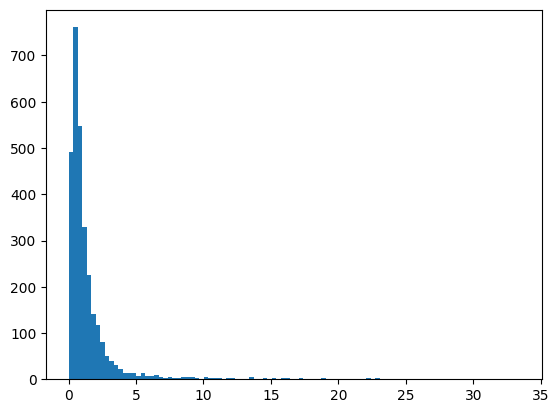

In [9]:
plt.hist(df["rmsd"], bins=100)
plt.show()

## Calculate perplexity

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

checkpoint = torch.load(
    "../model_params/model_weights/epoch_last.pt",
    map_location=device,
    weights_only=True,
)
protein_mpnn = ProteinMPNNBatch()
protein_mpnn.load_state_dict(checkpoint["model_state_dict"])
protein_mpnn.to(device)
protein_mpnn.eval()

ProteinMPNNBatch(
  (features): ProteinFeatures(
    (embeddings): PositionalEncodings(
      (linear): Linear(in_features=66, out_features=16, bias=True)
    )
    (edge_embedding): Linear(in_features=416, out_features=128, bias=False)
    (norm_edges): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (W_e): Linear(in_features=128, out_features=128, bias=True)
  (W_s): Embedding(21, 128)
  (dropout): Dropout(p=0.0, inplace=False)
  (encoder_layers): ModuleList(
    (0-2): 3 x EncLayer(
      (dropout1): Dropout(p=0.0, inplace=False)
      (dropout2): Dropout(p=0.0, inplace=False)
      (dropout3): Dropout(p=0.0, inplace=False)
      (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (norm3): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (W1): Linear(in_features=384, out_features=128, bias=True)
      (W2): Linear(in_features=128, out_features=128, bias=True)
      (W3): Line

In [4]:
df = pd.read_csv("./annotations/test_scores.csv")

In [28]:
df_large_rmsd = df[df["rmsd"] > 5]
scores = []
for row in tqdm(list(df_large_rmsd.itertuples())):
    cluster = row.cluster
    rmsd = row.rmsd

    feature_dir = f"./dataset/{cluster}"

    perplexity = run_scoring(protein_mpnn, feature_dir)[2].item()

    scores.append(
        [
            row.cluster,
            row.rmsd,
            perplexity,
        ]
    )
df_large_rmsd_scores = pd.DataFrame(scores, columns=["cluster", "rmsd", "perplexity"])
df_large_rmsd_scores.to_csv("./annotations/test_scores_large_rmsd.csv", index=False)

  0%|          | 0/126 [00:00<?, ?it/s]

In [7]:
df_small_rmsd = df[df["rmsd"] < 0.5]
scores = []
for row in tqdm(list(df_small_rmsd.itertuples())):
    cluster = row.cluster
    rmsd = row.rmsd

    feature_dir = f"./dataset/{cluster}"

    perplexity = run_scoring(protein_mpnn, feature_dir)[2].item()

    scores.append(
        [
            row.cluster,
            row.rmsd,
            perplexity,
        ]
    )
df_small_rmsd_scores = pd.DataFrame(scores, columns=["cluster", "rmsd", "perplexity"])
df_small_rmsd_scores.to_csv("./annotations/test_scores_small_rmsd.csv", index=False)

  0%|          | 0/912 [00:00<?, ?it/s]

## Plot perplexity

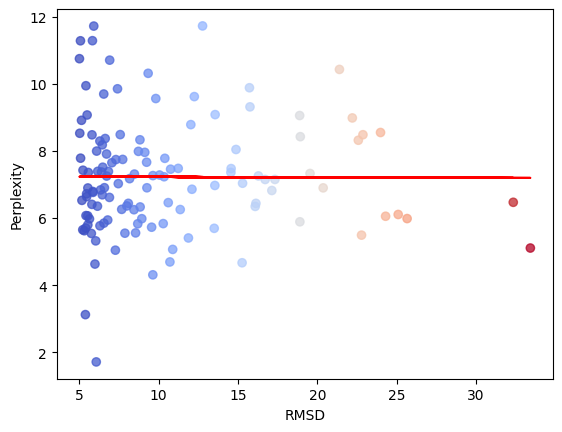

In [ ]:
df = pd.read_csv("../training/annotations/test_scores_large_rmsd.csv")
df = df[df["perplexity"] < 12]

# linear regression
slope, intercept = np.polyfit(df["rmsd"], df["perplexity"], 1)

# plot
plt.scatter(df["rmsd"], df["perplexity"], alpha=0.75, c=df["rmsd"], cmap="coolwarm")
plt.plot(df["rmsd"], slope * df["rmsd"] + intercept, color="red")
plt.xlabel("RMSD")
plt.ylabel("Perplexity")
plt.show()

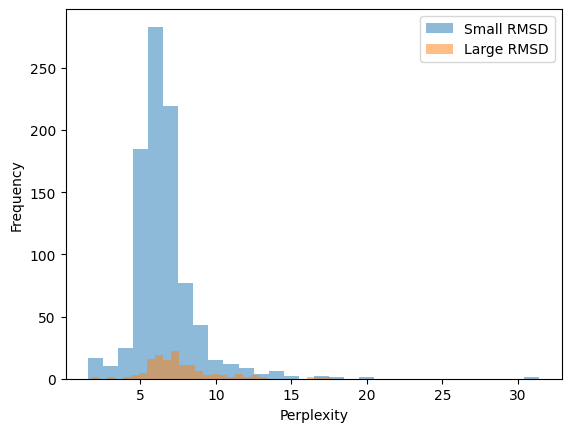

(6.579996319716437, 7.638048891700915)

In [19]:
df_small_rmsd_scores = pd.read_csv("../training/annotations/test_scores_small_rmsd.csv")
df_large_rmsd_scores = pd.read_csv("../training/annotations/test_scores_large_rmsd.csv")

plt.hist(df_small_rmsd_scores["perplexity"], bins=30, alpha=0.5)
plt.hist(df_large_rmsd_scores["perplexity"], bins=30, alpha=0.5)
plt.xlabel("Perplexity")
plt.ylabel("Frequency")
plt.legend(["Small RMSD", "Large RMSD"])
plt.show()

df_small_rmsd_scores["perplexity"].mean(), df_large_rmsd_scores["perplexity"].mean()